In [1]:
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
import gc
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from smart_open import open
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from keras.layers import Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# PREPARING DATA

In [2]:
dataset1 = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
dataset2 = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/full_test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
dataset3 = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]

dataset = np.concatenate((dataset1, np.concatenate((dataset2, dataset3))))


In [3]:
countPos = 0

def checkPosNeg(dataset, index):
    for i in range(0, len(dataset)):
        if(dataset[i][0] == index):
            return dataset[i][1]
    return 0

In [4]:
Data = []
Y = []

countPos = 0
index = -1
Data_test = []
Y_test = []

In [5]:
for i in range(0, len(dataset3)):
    val = checkPosNeg(dataset, dataset3[i][0])
    Y.append(val)
    try:
      fileName = "/content/drive/MyDrive/Dataset_Extracted/train_data/" + str(int(dataset3[i][0])) + "_TRANSCRIPT.csv"
      Data.append(np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))[:, 2:4])
    except Exception as e:
       print(e)

In [6]:
for i in range(0, len(dataset1)):
    val = checkPosNeg(dataset, dataset1[i][0])
    Y.append(val)
    try:
      fileName = "/content/drive/MyDrive/Dataset_Extracted/dev_data/" + str(int(dataset1[i][0])) + "_TRANSCRIPT.csv"
      Data.append(np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))[:, 2:4])
    except Exception as e:
       print(e)

In [7]:
for i in range(0, len(dataset2)):
    Y_test.append(checkPosNeg(dataset, dataset2[i][0]))
    try:
      fileName = "/content/drive/MyDrive/Dataset_Extracted/test_data/" + str(int(dataset2[i][0])) + "_TRANSCRIPT.csv"
      Data_test.append(np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))[:, 2:4])
    except Exception as e:
       print(e)

In [8]:
Y = np.array(Y)
Data2 = []

Data2_test = []
Y_test = np.array(Y_test)

In [9]:
for i in range(0, len(Data)):
    script = []
    for k in range(1, len(Data[i])):
        if(Data[i][k][0] == "Participant"):
            script.append(Data[i][k][1])
    Data2.append(script)

In [10]:
for i in range(0, len(Data_test)):
    script = []
    for k in range(1, len(Data_test[i])):
        if(Data_test[i][k][0] == "Participant"):
            script.append(Data_test[i][k][1])
    Data2_test.append(script)


In [11]:
Data = []
Data_test = []
gc.collect()


468

In [12]:
import numpy as np

# Step 1: Find the maximum length among all elements in both Data2 and Data2_test
max_length = max(max(len(element) for element in Data2), max(len(element_test) for element_test in Data2_test))

# Step 2: Pad the elements with smaller lengths to match the maximum length
padded_Data2 = []
for element in Data2:
    pad_width = (0, max_length - len(element))
    padded_element = np.pad(element, pad_width, mode='constant', constant_values=0)
    padded_Data2.append(padded_element)

padded_Data2_test = []
for element_test in Data2_test:
    pad_width = (0, max_length - len(element_test))
    padded_element_test = np.pad(element_test, pad_width, mode='constant', constant_values=0)
    padded_Data2_test.append(padded_element_test)

# Step 3: Convert the padded data to NumPy arrays
Data2 = np.array(padded_Data2)
Data2_test = np.array(padded_Data2_test)



In [13]:
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)
stop_words = set(stopwords.words('english'))

In [14]:
def Thresholding(Y_pred, threshold):
  Y_pred2 = []
  for i in range(len(Y_pred)):
    if(Y_pred[i] < threshold):
      Y_pred2.append(0)
    else:
      Y_pred2.append(1)

  return np.array(Y_pred2)

In [15]:
def remove_StopWords(sentence):
    filtered_sentence = []
    for w in sentence:
        if w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence

In [16]:
def checkAcc(Y_pred, Y_test):
    correct = 0
    for i in range(len(Y_pred)):
        if(Y_pred[i] == Y_test[i]):
            correct+=1

    return float(correct)/len(Y_pred)

In [17]:
def upsample(X_train, Y_train):
    X_train_0 = X_train[Y_train == 0]
    X_train_1 = X_train[Y_train == 1]

    Y_train_1 = Y_train[Y_train == 1]
    size = X_train_0.shape[0] - X_train_1.shape[0]

    while size > 0:
        size -= 1
        index = np.random.randint(0, X_train_1.shape[0] - 1)
        leave_index = np.random.randint(0, len(X_train) - 1)

        X_add = X_train_1[index]
        X_leave = X_train[leave_index]

        Y_add = Y_train_1[index]
        Y_leave = Y_train[leave_index]

        X_train[leave_index] = X_add
        X_train = np.append(X_train, [X_leave], axis=0)

        Y_train[leave_index] = Y_add
        Y_train = np.append(Y_train, [Y_leave], axis=0)

    return X_train, Y_train




In [18]:
import numpy as np

max_num_words = 20
max_num_sentence = 250

#train_data
finalMatrix = np.zeros((Data2.shape[0], max_num_sentence, max_num_words, 300))
max_length_sent = 0
sent = ""
for k in range(Data2.shape[0]):
	if(max_length_sent < len(Data2[k])):
		max_length_sent = len(Data2[k])
		sent = Data2[k]
	for i in range(min(max_num_sentence, len(Data2[k]))):
		try:
			sentence = Data2[k][i].split(" ")
		except:
			continue
		sentence = remove_StopWords(sentence)
		for j in range(min(max_num_words, len(sentence))):
			try:
				word = sentence[j]
				# print("Before", word)
				if(word[0] == '<'):
					if(word.find('>')!=-1):
						word = word[1:-1]
					else:
						word = word[1:]
				else:
					if(word.find('>')!=-1):
						word = word[0:-1]
				finalMatrix[k][i][j] = np.array(model[word])
			except Exception as e:
				continue


In [19]:
import numpy as np

max_length_sent = 0
finalMatrix_test = np.zeros((Data2_test.shape[0], max_num_sentence, max_num_words, 300))
# print(finalMatrix_test.shape)

for k in range(Data2_test.shape[0]):
	if(max_length_sent < len(Data2_test[k])):
		max_length_sent = len(Data2_test[k])
		sent = Data2_test[k]
	for i in range(min(max_num_sentence, len(Data2_test[k]))):
		try:
			sentence = Data2_test[k][i].split(" ")
		except:
			continue
		sentence = remove_StopWords(sentence)
		for j in range(min(max_num_words, len(sentence))):
			try:
				word = sentence[j]
				if(word[0] == '<'):
					if(word.find('>') != -1):
						word = word[1:-1]
					else:
						word = word[1:]
				else:
					if(word.find('>') != -1):
						word = word[0:-1]
				finalMatrix_test[k][i][j] = np.array(model[word])
			except Exception as e:
				continue


In [20]:
Data2 = []
Data2_test = []
model = []
stop_words = []
gc.collect()



0

In [21]:
finalMatrix, Y = upsample(finalMatrix,Y)
finalMatrix_test, Y_test = upsample(finalMatrix_test,Y_test)



In [22]:
class CNN_Text:
  def __init__(self):
    # Initialising the CNN
    classifier = Sequential()
    # Step 1 - Convolution
    classifier.add(Conv2D(150, (1, 5), input_shape = (finalMatrix.shape[1], finalMatrix.shape[2], finalMatrix.shape[3]), activation = 'relu', data_format="channels_last"))
    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (1, 3)))
    # Adding a second convolutional layer
    classifier.add(Conv2D(75, (1, 3), activation = 'relu', data_format="channels_last"))
    classifier.add(MaxPooling2D(pool_size = (1, 2)))
    # Step 3 - Flattening
    classifier.add(Flatten())
    # Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    self.classifier = classifier

  def fitModel(self, X, Y, epoch = 50):
    class_weight = {0: 0.5, 1: 0.6}
    self.classifier.fit(X, Y, epochs = epoch, class_weight=class_weight)

  def predictModel(self, X):
    return Thresholding(self.classifier.predict(X), 0.5)

In [23]:
model = CNN_Text()
model.fitModel(finalMatrix, Y, 50)


Epoch 1/50
7/7 [==============================] - 4s 297ms/step - loss: 0.3978 - accuracy: 0.6250
Epoch 2/50
7/7 [==============================] - 2s 292ms/step - loss: 0.3490 - accuracy: 0.7050
Epoch 3/50
7/7 [==============================] - 2s 284ms/step - loss: 0.2950 - accuracy: 0.7150
Epoch 4/50
7/7 [==============================] - 2s 286ms/step - loss: 0.2541 - accuracy: 0.8050
Epoch 5/50
7/7 [==============================] - 2s 287ms/step - loss: 0.2181 - accuracy: 0.7950
Epoch 6/50
7/7 [==============================] - 2s 281ms/step - loss: 0.2243 - accuracy: 0.8000
Epoch 7/50
7/7 [==============================] - 2s 280ms/step - loss: 0.1948 - accuracy: 0.8300
Epoch 8/50
7/7 [==============================] - 2s 281ms/step - loss: 0.2005 - accuracy: 0.8250
Epoch 9/50
7/7 [==============================] - 2s 286ms/step - loss: 0.1976 - accuracy: 0.8000
Epoch 10/50
7/7 [==============================] - 2s 286ms/step - loss: 0.2001 - accuracy: 0.8500
Epoch 11/50
7/7 [==

3/3 [==============================] - 0s 45ms/step


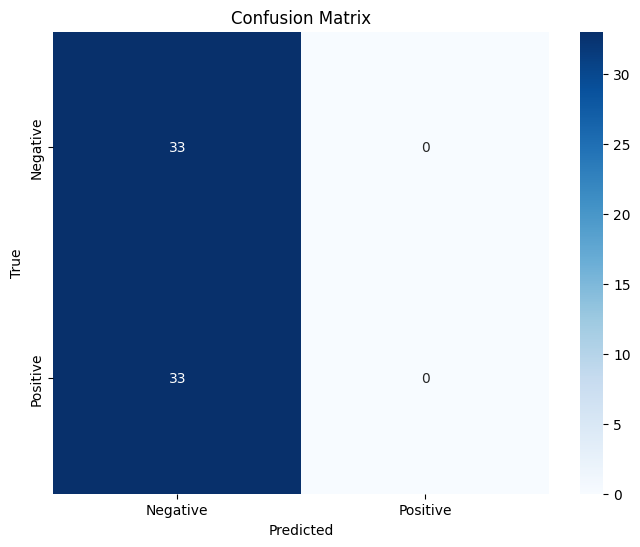

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_Pred = model.predictModel(finalMatrix_test)
# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_Pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
# Print classification report
print("Classification Report:")
print(classification_report(Y_test, Y_Pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        33
         1.0       0.00      0.00      0.00        33

    accuracy                           0.50        66
   macro avg       0.25      0.50      0.33        66
weighted avg       0.25      0.50      0.33        66



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
